In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

# 2 following lines are required by AWS EC2 instance, for some reason
plt.switch_backend('TkAgg')
%matplotlib inline

all_levels = pd.read_csv('./csv/rivers.csv')

np.random.seed(7)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]

def create_datasets(dataset, look_back=1, look_ahead=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-look_ahead+1):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)

def build_seq2seq_model(look_ahead = 1):
    m = Sequential()
    # encoder
    m.add(GRU(16, input_dim = 1))
    # repeat for the number of steps out
    m.add(RepeatVector(look_ahead))
    # decoder
    m.add(GRU(8, return_sequences=True))
    m.add(GRU(8, return_sequences=True))
    # split the output into timesteps
    m.add(TimeDistributed(Dense(1)))
    m.compile(loss='mse', optimizer='rmsprop')
    #m.summary()
    return m

def reverse_scale(data, mean, std):
    for x in np.nditer(data, op_flags=['readwrite']):
        x[...] = x*std + mean
    return data

def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score

def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [11]:
for i in range(len(test_y)/20):
    x = np.arange(i*20, i*20+19,1)
    plt.plot(x, test_y[i*20,:,:], color="blue")
    plt.plot(x, pred_test[i*20,:,:], color="red")
plt.show()

NameError: name 'test_y' is not defined

In [12]:
def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print i+1, "  ->  ", score
        
    return score

In [13]:
def plot_4_errors(pred_test, test_y, er1, er2, er3, er4):
    plt.subplot(221)
    plt.plot(test_y[:,0,:], label="Observed")
    plt.plot(pred_test[:,0,:], color="red", label="Predicted, MAPE: "+ str(round(er1, 5))+"%")
    plt.title("1 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(222)
    plt.plot(pred_test[:,3,:], color="red", label="Predicted, MAPE: "+ str(round(er2, 5))+"%")
    plt.plot(test_y[:,3,:], label="Observed")
    plt.title("4 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(223)
    plt.plot(pred_test[:,7,:], color="red", label="Predicted, MAPE: "+ str(round(er3, 5))+"%")
    plt.plot(test_y[:,7,:], label="Observed")
    plt.title("8 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(224)
    plt.plot(pred_test[:,15,:], color="red", label="Predicted, MAPE: "+ str(round(er4, 5))+"%")
    plt.plot(test_y[:,15,:], label="Observed")
    plt.title("16 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.show()

In [20]:
def do_everything(look_back, look_ahead, riverstation_id, split, epochs, batch_size):
    river = all_levels[all_levels['riverstation_id'] == riverstation_id]['level'].values
    river_mean, river_std = river.mean(), river.std()
    river = preprocessing.scale(river).reshape(len(river), 1)

    #split data into train and test subsets
    train, test = train_test_split(river, split)
    train_x, train_y = create_datasets(train, look_back, look_ahead)
    test_x, test_y = create_datasets(test, look_back, look_ahead)

    #reshape the data to match Keras LSTM gate input [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))

    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    test_y = np.reshape(test_y, (test_y.shape[0], test_y.shape[1], 1))

    model = build_seq2seq_model(look_ahead)

    model.fit(train_x, 
              train_y, 
              nb_epoch=epochs, 
              batch_size=batch_size, 
              verbose=2,
              validation_split = 0.1,
              callbacks = [
                EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=2, mode='auto')
              ]
             )

    pred_train = model.predict(train_x)
    pred_test = model.predict(test_x)

    pred_train = reverse_scale(pred_train, river_mean, river_std)
    pred_test = reverse_scale(pred_test, river_mean, river_std)
    test_y = reverse_scale(test_y, river_mean, river_std)
    train_y = reverse_scale(train_y, river_mean, river_std)
    
    errors = []
    for i in range(20):
        errors.append(mean_absolute_percentage(test_y[:,i,:], pred_test[:,i,:]))
        
    plot_4_errors(pred_test, test_y, errors[0], errors[3], errors[7], errors[15])
    #root_mse(pred_test, test_y)
    
    errors = []
    for i in range(20):
        errors.append(mean_absolute_percentage(test_y[:,i,:], pred_test[:,i,:]))
        
    return errors

Train on 2549 samples, validate on 284 samples
Epoch 1/50
47s - loss: 0.0821 - val_loss: 0.0207
Epoch 2/50
44s - loss: 0.0217 - val_loss: 0.0112
Epoch 3/50
45s - loss: 0.0144 - val_loss: 0.0070
Epoch 4/50
44s - loss: 0.0117 - val_loss: 0.0076
Epoch 5/50
44s - loss: 0.0106 - val_loss: 0.0071
Epoch 6/50
44s - loss: 0.0098 - val_loss: 0.0093
Epoch 7/50
45s - loss: 0.0088 - val_loss: 0.0077
Epoch 00006: early stopping


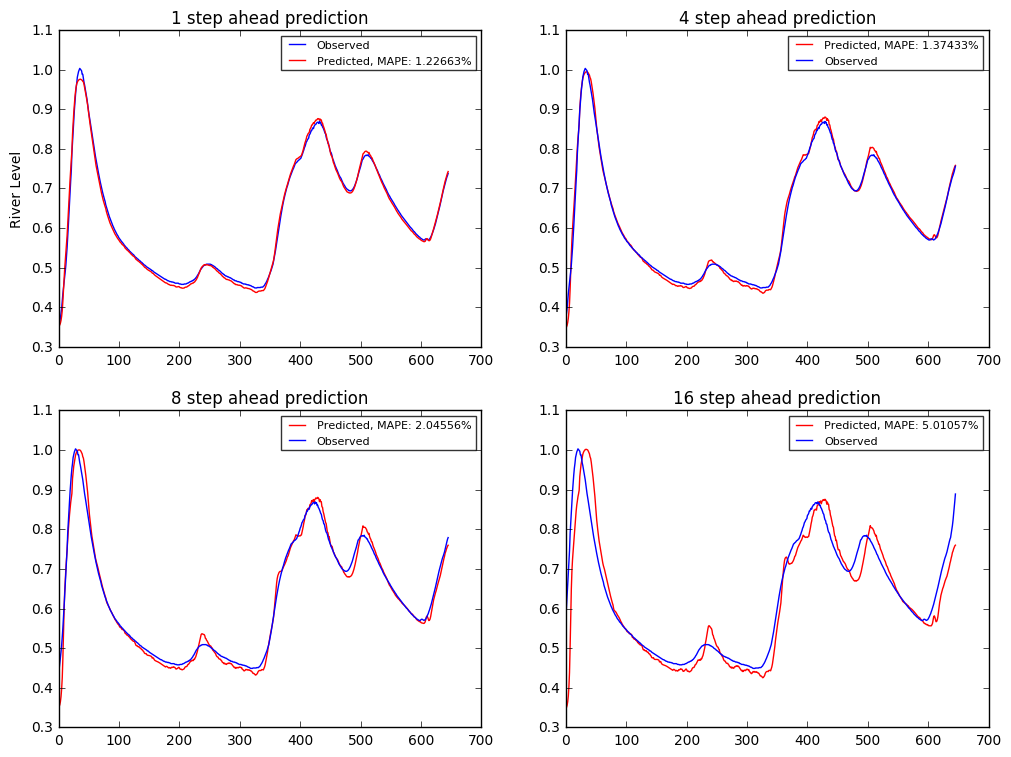

Train on 2522 samples, validate on 281 samples
Epoch 1/50
51s - loss: 0.4369 - val_loss: 0.2585
Epoch 2/50
47s - loss: 0.2254 - val_loss: 0.1693
Epoch 3/50
46s - loss: 0.1910 - val_loss: 0.1816
Epoch 4/50
46s - loss: 0.1684 - val_loss: 0.1620
Epoch 5/50
46s - loss: 0.1454 - val_loss: 0.0957
Epoch 6/50
47s - loss: 0.1273 - val_loss: 0.0721
Epoch 7/50
46s - loss: 0.1145 - val_loss: 0.0909
Epoch 8/50
46s - loss: 0.1067 - val_loss: 0.1070
Epoch 9/50
46s - loss: 0.1006 - val_loss: 0.1099
Epoch 10/50
47s - loss: 0.0948 - val_loss: 0.1242
Epoch 00009: early stopping


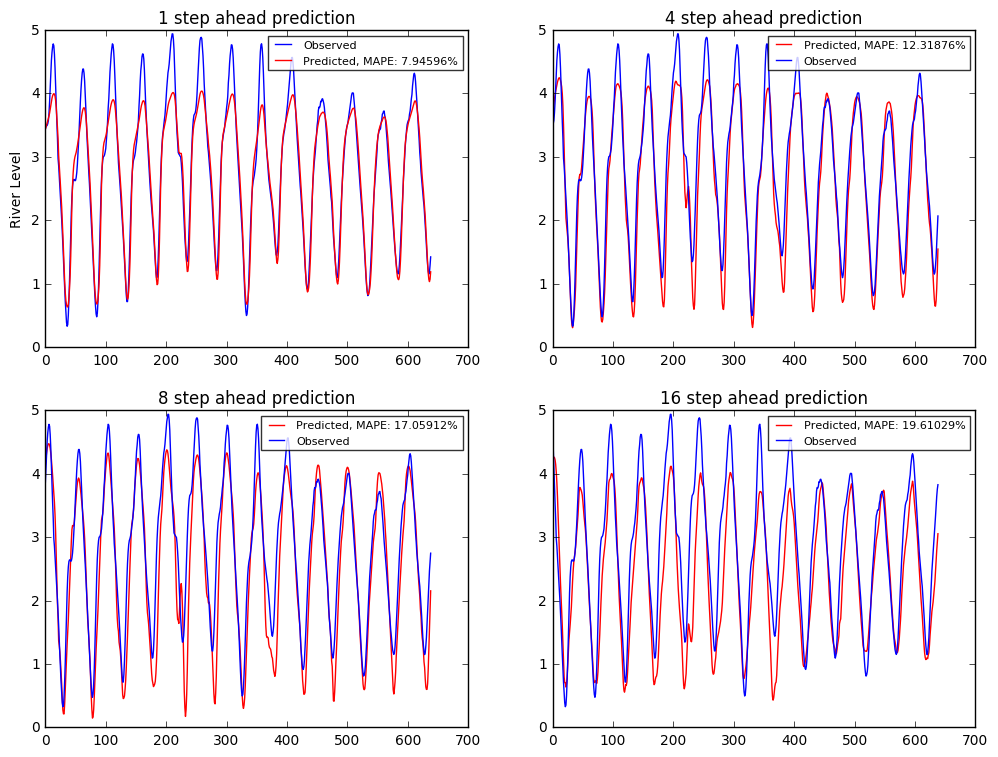

Train on 2517 samples, validate on 280 samples
Epoch 1/50
50s - loss: 0.0950 - val_loss: 0.0137
Epoch 2/50
47s - loss: 0.0302 - val_loss: 0.0061
Epoch 3/50
47s - loss: 0.0176 - val_loss: 0.0041
Epoch 4/50
47s - loss: 0.0140 - val_loss: 0.0037
Epoch 5/50
50s - loss: 0.0135 - val_loss: 0.0037
Epoch 6/50
51s - loss: 0.0129 - val_loss: 0.0027
Epoch 7/50
52s - loss: 0.0122 - val_loss: 0.0124
Epoch 8/50
55s - loss: 0.0116 - val_loss: 0.0164
Epoch 9/50
54s - loss: 0.0110 - val_loss: 0.0048
Epoch 10/50
48s - loss: 0.0105 - val_loss: 0.0037
Epoch 00009: early stopping


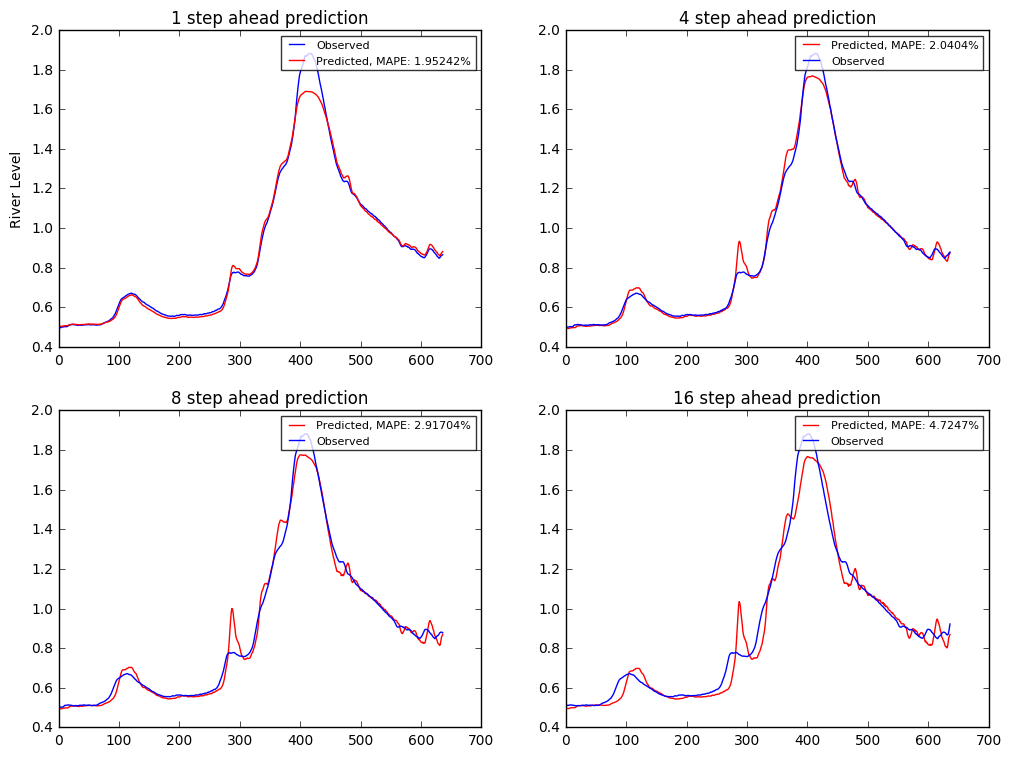

Train on 2522 samples, validate on 281 samples
Epoch 1/50
50s - loss: 0.1653 - val_loss: 0.0297
Epoch 2/50
47s - loss: 0.0645 - val_loss: 0.0210
Epoch 3/50
47s - loss: 0.0451 - val_loss: 0.0246
Epoch 4/50
47s - loss: 0.0394 - val_loss: 0.0174
Epoch 5/50
47s - loss: 0.0362 - val_loss: 0.0213
Epoch 6/50
47s - loss: 0.0333 - val_loss: 0.0240
Epoch 7/50
54s - loss: 0.0317 - val_loss: 0.0206
Epoch 8/50
63s - loss: 0.0309 - val_loss: 0.0225
Epoch 00007: early stopping


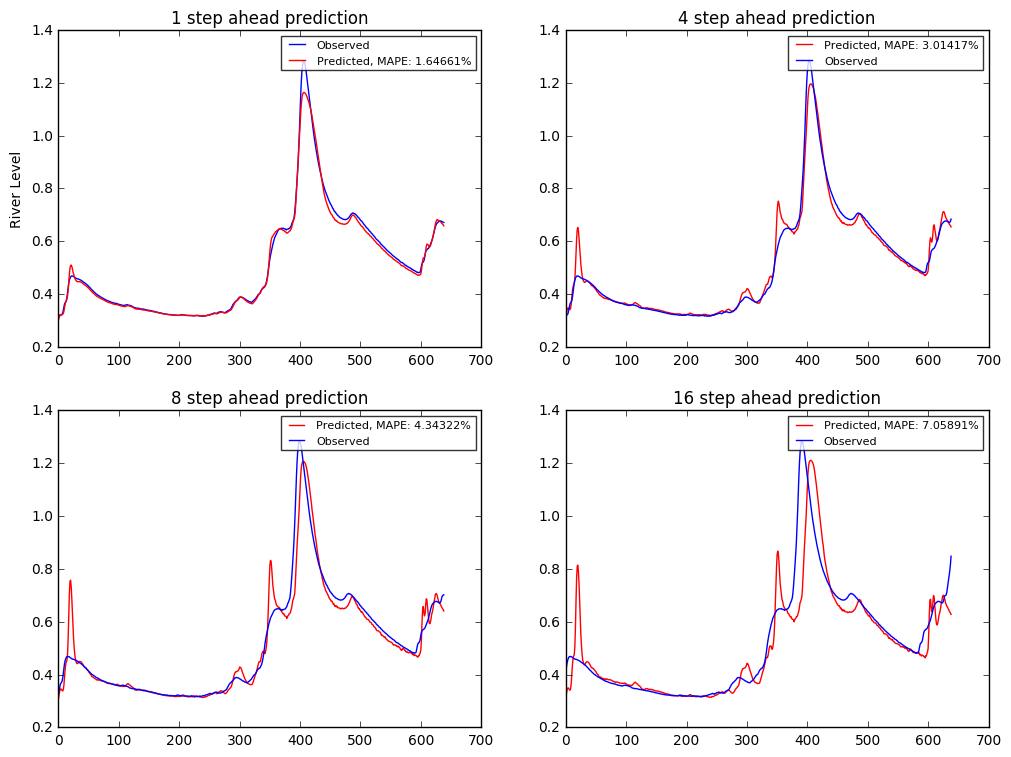

Train on 2517 samples, validate on 280 samples
Epoch 1/50
67s - loss: 0.1606 - val_loss: 0.0677
Epoch 2/50
59s - loss: 0.0585 - val_loss: 0.0645
Epoch 3/50
60s - loss: 0.0499 - val_loss: 0.0704
Epoch 4/50
59s - loss: 0.0462 - val_loss: 0.0573
Epoch 5/50
61s - loss: 0.0434 - val_loss: 0.0494
Epoch 6/50
60s - loss: 0.0423 - val_loss: 0.0480
Epoch 7/50
60s - loss: 0.0409 - val_loss: 0.0529
Epoch 8/50
59s - loss: 0.0403 - val_loss: 0.0514
Epoch 9/50
62s - loss: 0.0402 - val_loss: 0.0453
Epoch 10/50
46s - loss: 0.0398 - val_loss: 0.0529
Epoch 11/50
58s - loss: 0.0397 - val_loss: 0.0553
Epoch 12/50
61s - loss: 0.0388 - val_loss: 0.0708
Epoch 13/50
60s - loss: 0.0388 - val_loss: 0.0751
Epoch 00012: early stopping


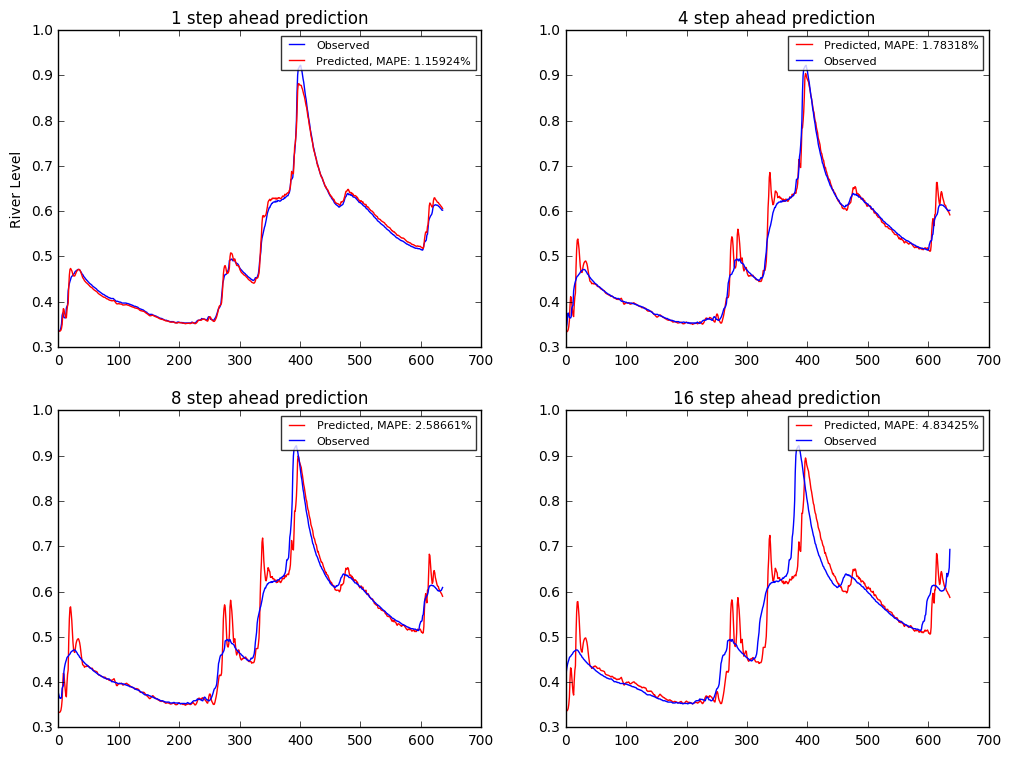

Train on 2522 samples, validate on 281 samples
Epoch 1/50
67s - loss: 0.0704 - val_loss: 0.0169
Epoch 2/50
59s - loss: 0.0229 - val_loss: 0.0098
Epoch 3/50
58s - loss: 0.0175 - val_loss: 0.0077
Epoch 4/50
59s - loss: 0.0165 - val_loss: 0.0099
Epoch 5/50
51s - loss: 0.0157 - val_loss: 0.0079
Epoch 6/50
46s - loss: 0.0154 - val_loss: 0.0077
Epoch 7/50
60s - loss: 0.0150 - val_loss: 0.0090
Epoch 00006: early stopping


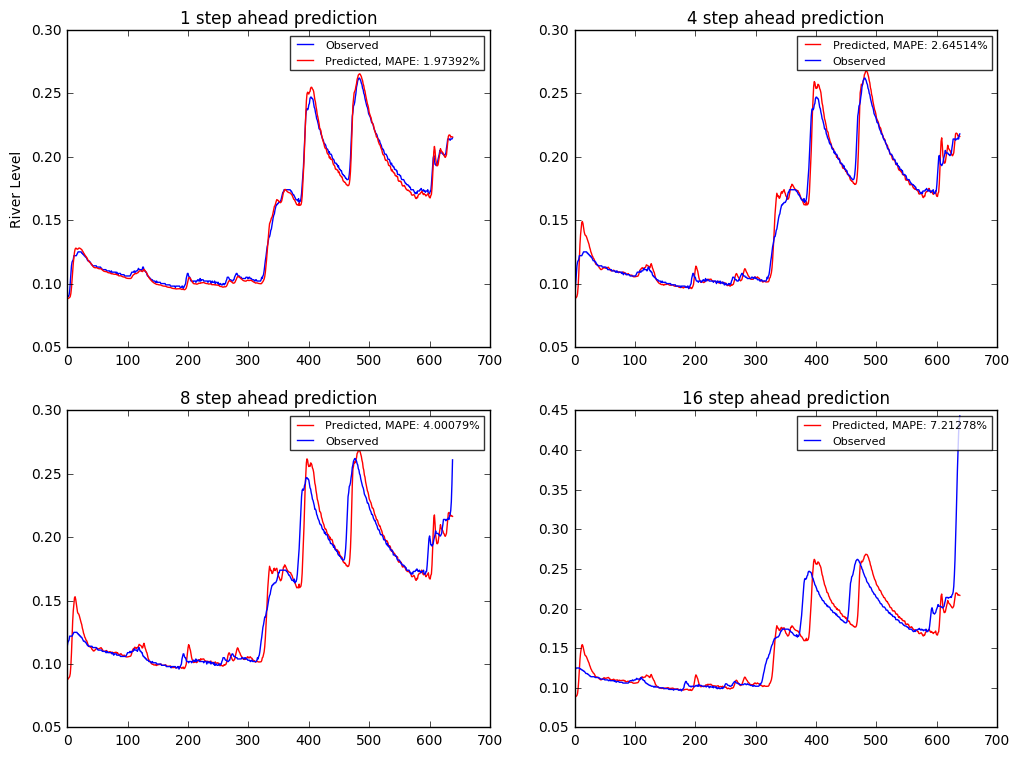

Train on 2522 samples, validate on 281 samples
Epoch 1/50
65s - loss: 0.0977 - val_loss: 0.0159
Epoch 2/50
59s - loss: 0.0379 - val_loss: 0.0077
Epoch 3/50
60s - loss: 0.0288 - val_loss: 0.0103
Epoch 4/50
60s - loss: 0.0254 - val_loss: 0.0075
Epoch 5/50
59s - loss: 0.0237 - val_loss: 0.0051
Epoch 6/50
60s - loss: 0.0224 - val_loss: 0.0049
Epoch 7/50
61s - loss: 0.0209 - val_loss: 0.0172
Epoch 8/50
59s - loss: 0.0204 - val_loss: 0.0071
Epoch 9/50
59s - loss: 0.0194 - val_loss: 0.0060
Epoch 00008: early stopping


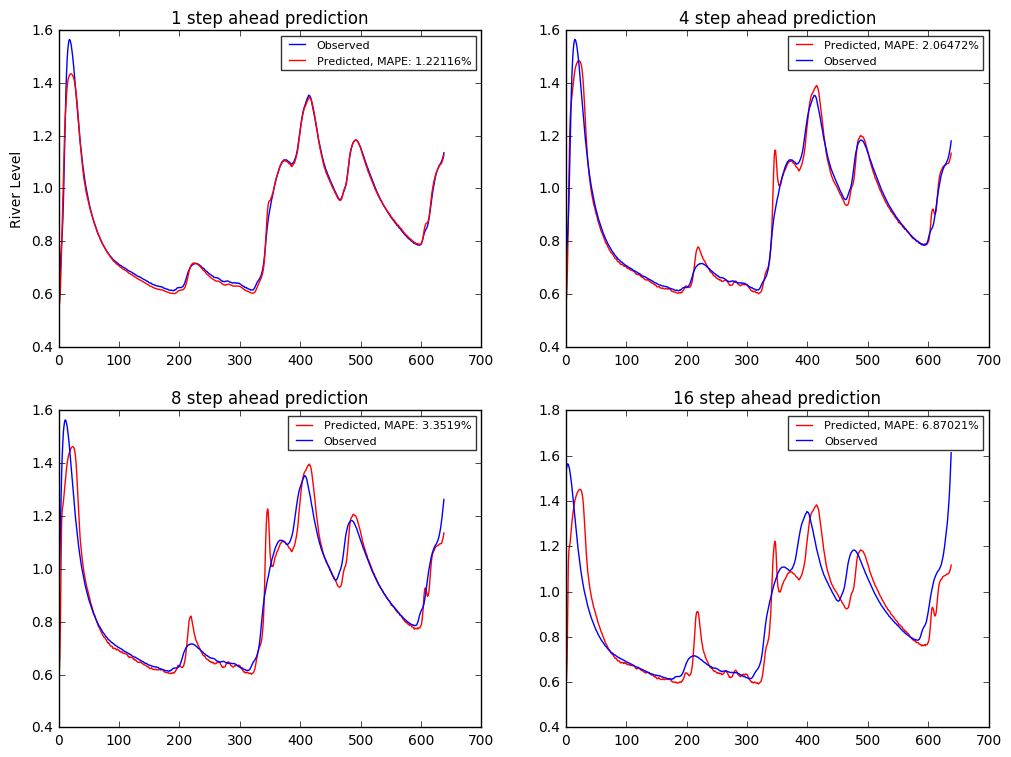

Train on 2522 samples, validate on 281 samples
Epoch 1/50
70s - loss: 0.1270 - val_loss: 0.0176
Epoch 2/50
59s - loss: 0.0306 - val_loss: 0.0267
Epoch 3/50
59s - loss: 0.0204 - val_loss: 0.0333
Epoch 4/50
59s - loss: 0.0159 - val_loss: 0.0081
Epoch 5/50
59s - loss: 0.0137 - val_loss: 0.0118
Epoch 6/50
59s - loss: 0.0124 - val_loss: 0.0063
Epoch 7/50
59s - loss: 0.0114 - val_loss: 0.0075
Epoch 8/50
59s - loss: 0.0108 - val_loss: 0.0044
Epoch 9/50
58s - loss: 0.0100 - val_loss: 0.0050
Epoch 10/50
59s - loss: 0.0096 - val_loss: 0.0065
Epoch 11/50
58s - loss: 0.0096 - val_loss: 0.0072
Epoch 12/50
59s - loss: 0.0089 - val_loss: 0.0078
Epoch 00011: early stopping


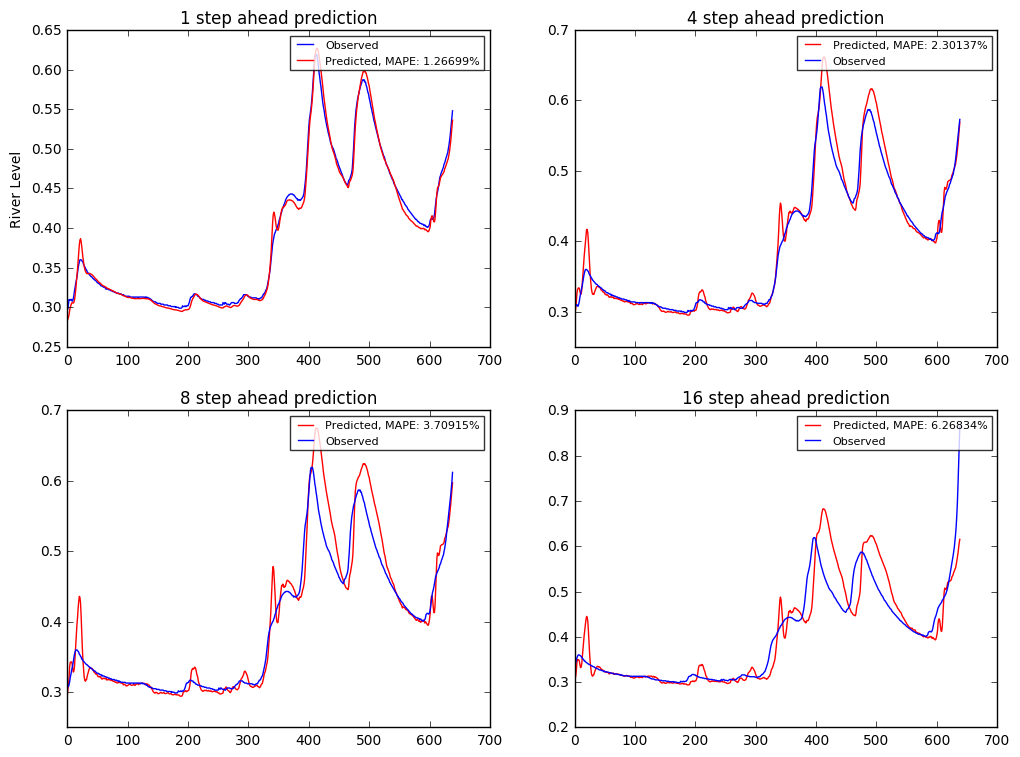

Train on 2522 samples, validate on 281 samples
Epoch 1/50
65s - loss: 0.0900 - val_loss: 0.0139
Epoch 2/50
59s - loss: 0.0363 - val_loss: 0.0108
Epoch 3/50
59s - loss: 0.0295 - val_loss: 0.0120
Epoch 4/50
59s - loss: 0.0273 - val_loss: 0.0098
Epoch 5/50
58s - loss: 0.0267 - val_loss: 0.0451
Epoch 6/50
47s - loss: 0.0261 - val_loss: 0.0135
Epoch 00005: early stopping


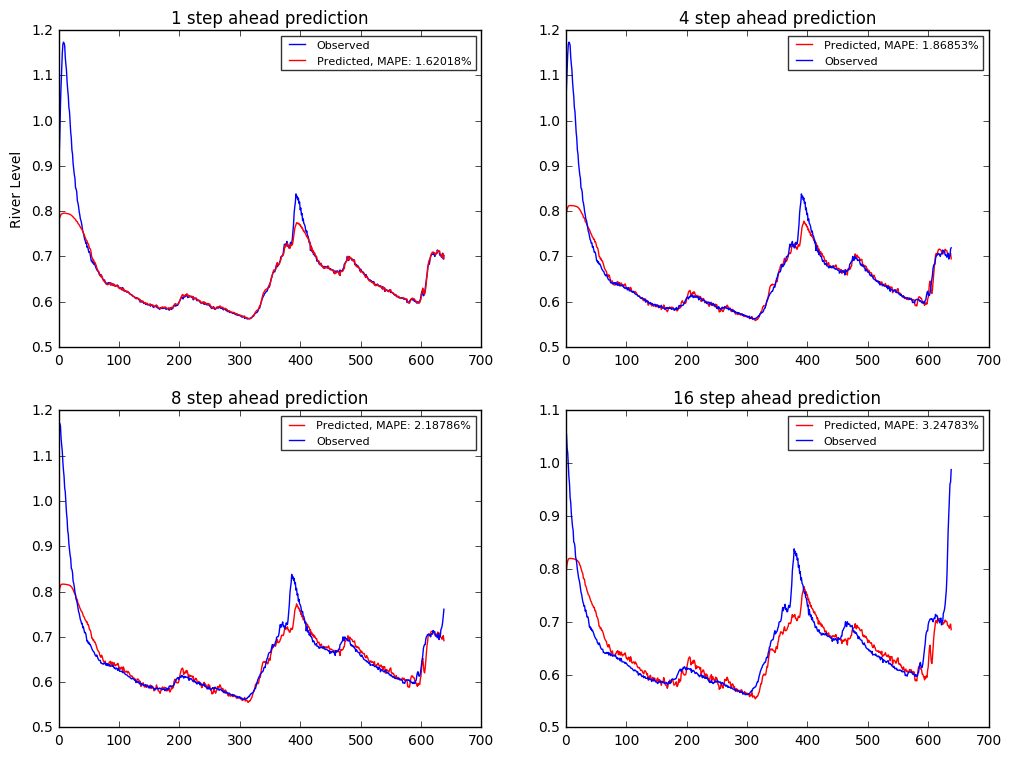

Train on 2522 samples, validate on 281 samples
Epoch 1/50
50s - loss: 0.0809 - val_loss: 0.0358
Epoch 2/50
48s - loss: 0.0470 - val_loss: 0.0157
Epoch 3/50
46s - loss: 0.0375 - val_loss: 0.0174
Epoch 4/50
46s - loss: 0.0339 - val_loss: 0.0165
Epoch 5/50
46s - loss: 0.0328 - val_loss: 0.0242
Epoch 6/50
46s - loss: 0.0313 - val_loss: 0.0261
Epoch 00005: early stopping


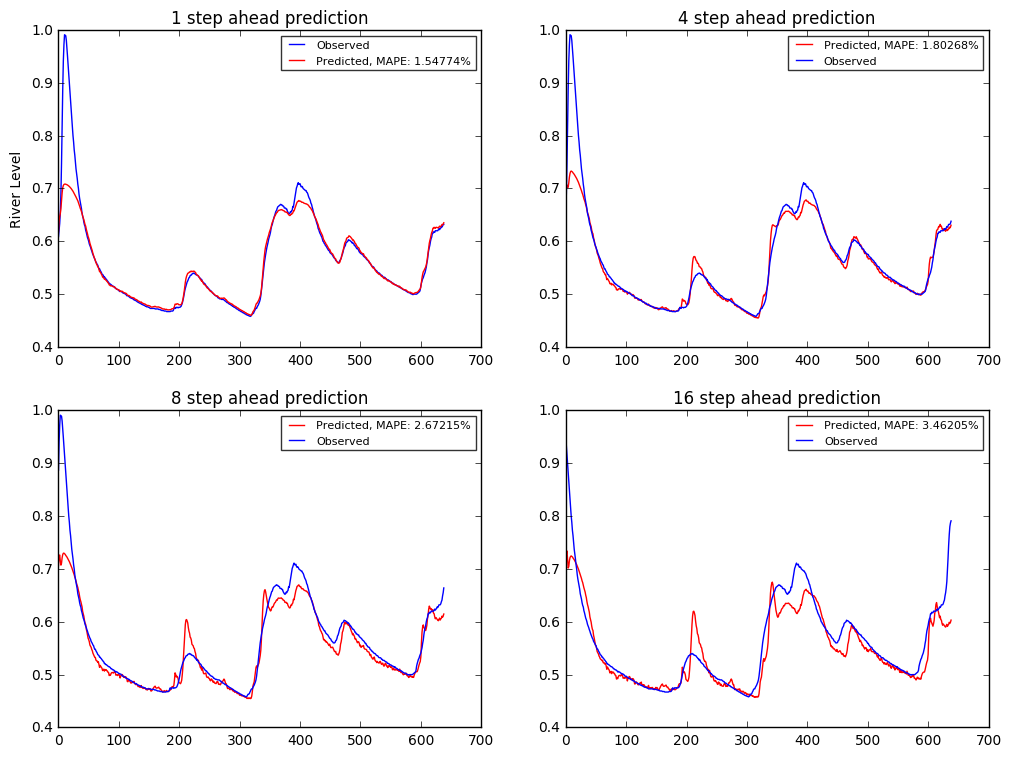

In [21]:
scores = []
for i in range(1,11):
    err = do_everything(look_back=64,
                        look_ahead=20,
                        riverstation_id=i,
                        split=0.8,
                        epochs=50,
                        batch_size=10)
    scores.append(err)

In [19]:
print len(scores[0])

20


In [31]:
for i in range(20):
    print "\hline"
    print i+1, " & ",
    for r in scores[:-1]:
        print round(r[i],3), "\% & ",
    print round(scores[-1][i],3), "\%",
    print "\\\\"
    
print "\hline"

\hline
1  &  1.227 \% &  7.946 \% &  1.952 \% &  1.647 \% &  1.159 \% &  1.974 \% &  1.221 \% &  1.267 \% &  1.62 \% &  1.548 \% \\
\hline
2  &  1.228 \% &  8.488 \% &  1.718 \% &  2.599 \% &  1.246 \% &  2.016 \% &  1.933 \% &  1.6 \% &  1.755 \% &  1.783 \% \\
\hline
3  &  1.279 \% &  10.406 \% &  1.92 \% &  2.611 \% &  1.516 \% &  2.343 \% &  1.92 \% &  1.93 \% &  1.802 \% &  1.672 \% \\
\hline
4  &  1.374 \% &  12.319 \% &  2.04 \% &  3.014 \% &  1.783 \% &  2.645 \% &  2.065 \% &  2.301 \% &  1.869 \% &  1.803 \% \\
\hline
5  &  1.465 \% &  14.312 \% &  2.324 \% &  3.29 \% &  2.016 \% &  2.98 \% &  2.124 \% &  2.688 \% &  1.95 \% &  2.015 \% \\
\hline
6  &  1.594 \% &  15.82 \% &  2.54 \% &  3.588 \% &  2.229 \% &  3.324 \% &  2.42 \% &  3.063 \% &  2.03 \% &  2.255 \% \\
\hline
7  &  1.79 \% &  16.698 \% &  2.737 \% &  3.953 \% &  2.406 \% &  3.653 \% &  2.868 \% &  3.401 \% &  2.103 \% &  2.483 \% \\
\hline
8  &  2.046 \% &  17.059 \% &  2.917 \% &  4.343 \% &  2.587 \% &  4.001

In [32]:
averages = []
for i in range(20):
    sum = 0
    for r in scores:
        sum+=r[i]
    averages.append(sum/10)
    print i+1, " & ",round(sum/10, 3), "\% \\\\"
    print '\hline'
    


1  &  2.156 \% \\
\hline
2  &  2.437 \% \\
\hline
3  &  2.74 \% \\
\hline
4  &  3.121 \% \\
\hline
5  &  3.516 \% \\
\hline
6  &  3.886 \% \\
\hline
7  &  4.209 \% \\
\hline
8  &  4.487 \% \\
\hline
9  &  4.744 \% \\
\hline
10  &  5.008 \% \\
\hline
11  &  5.297 \% \\
\hline
12  &  5.603 \% \\
\hline
13  &  5.91 \% \\
\hline
14  &  6.211 \% \\
\hline
15  &  6.522 \% \\
\hline
16  &  6.83 \% \\
\hline
17  &  7.134 \% \\
\hline
18  &  7.454 \% \\
\hline
19  &  7.807 \% \\
\hline
20  &  8.209 \% \\
\hline


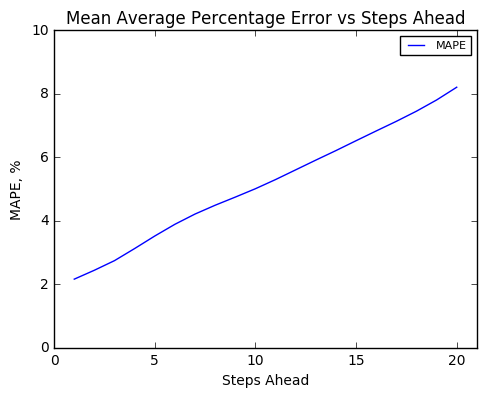

In [24]:
plt.subplot(221)
plt.plot(range(1,21),averages, label="MAPE")
plt.title("Mean Average Percentage Error vs Steps Ahead")
plt.ylabel("MAPE, %")
plt.xlabel("Steps Ahead")
plt.legend(loc=1, fontsize=8)
plt.ylim([0,10])
plt.xlim([0, 21])
plt.show()